In [1]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.optimize import root as sp_root
from collections import Counter

from utils.solvers import FirstOrderDiffEqn
from utils.solvers.firstorder import num_sol_runge_kutta,num_sol_euler
from utils.plot.utils import draw_circle, draw_arrow, plot_second_order_phase_portrait

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

# Chapter 6 - Phase Plane

Consider a general second-order vector field
$$
\begin{equation}
\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x})
\end{equation}
$$
where $\mathbf{x} = (x_1, x_2)$ and $\mathbf{f}(\mathbf{x}) = (f_1(\mathbf{x}), f_2(\mathbf{x}))$
- **Trajectories** are defined by integrating $\dot{\mathbf{x}}$
  - Runge-Kutta can easily be extended to n-dimensions
- **Nullclines** are curves where $\dot{x_1} = 0$ or $\dot{x_2} = 0$ i.e. the flow is purely vertical/horizontal
  - Useful as they partition the plane into different directions (i.e. they represent turning points for the flow direction)
- **Existence and uniqueness theorem** extends to n-dimensions
  - As long as the vector field is continuously differentiable
  - Means that two trajectories can't intersect (otherwise intersection point wouldn't have a unique value)
    - A trajectory inside of a closed orbit can't escape
- Second order systems can be linearised in the same way as first-order systems
  - Taylor expansion about a fixed point $(x^*, y^*)$ gives $\dot{x} = \dot{u} = f(x^*, y^*) + u\partial_x f + v\partial_y f + O(u^2, v^2, uv)$ where $u = x - x^*, v = y - y^*$ are small perturbations, similarly for $\dot{v}$
  - Thus
$$
\begin{equation}
\begin{pmatrix} \dot{u} \\ \dot{v} \end{pmatrix} = A \begin{pmatrix} u \\ v \end{pmatrix}
\end{equation}
$$
where
$$
\begin{equation}
A = \begin{pmatrix} \partial_x f & \partial_y f \\ \partial_x g & \partial_y g \end{pmatrix}_{(x^*, y^*)}
\end{equation}
$$
is called the **Jacobian**
- Can use the same methods as in the last chapter to analyze
- For an attracting point, the set of all points whose trajectory ends up at the fixed point is called its **boundary of attraction**
- A quantity which is constant along all trajectories but not constant on all open sets is called a **conserved quantity**
  - A system with such a quantity is a **conservative system**
- A system with **time-reversal symmetry** is any system which is invariant under $t \to -t$
  - A **reversible** system is any system with a mapping $R(\mathbf{x})$ such that $R^2(\mathbf{x}) = \mathbf{x}$ and the system is invariant under $t \to -t$ and $\mathbf{x} \to R(\mathbf{x})$


## Pendulum

### No Friction

Defined by
$$
\begin{equation}
\ddot{\theta} + \sin{\theta} = 0
\end{equation}
$$
It follows that
$$
\begin{split}
 & \dot{\theta}(\ddot{\theta} + \sin{\theta}) = 0 \\
\implies & \frac{1}{2}\dot{\theta}^2 - \cos(\theta) = \text{const} \\
\implies & E = \frac{1}{2} v^2 - \cos(\theta)
\end{split}
$$
Where $E$ is a constant and $v = \dot{\theta}$, thus it is a conservative system.

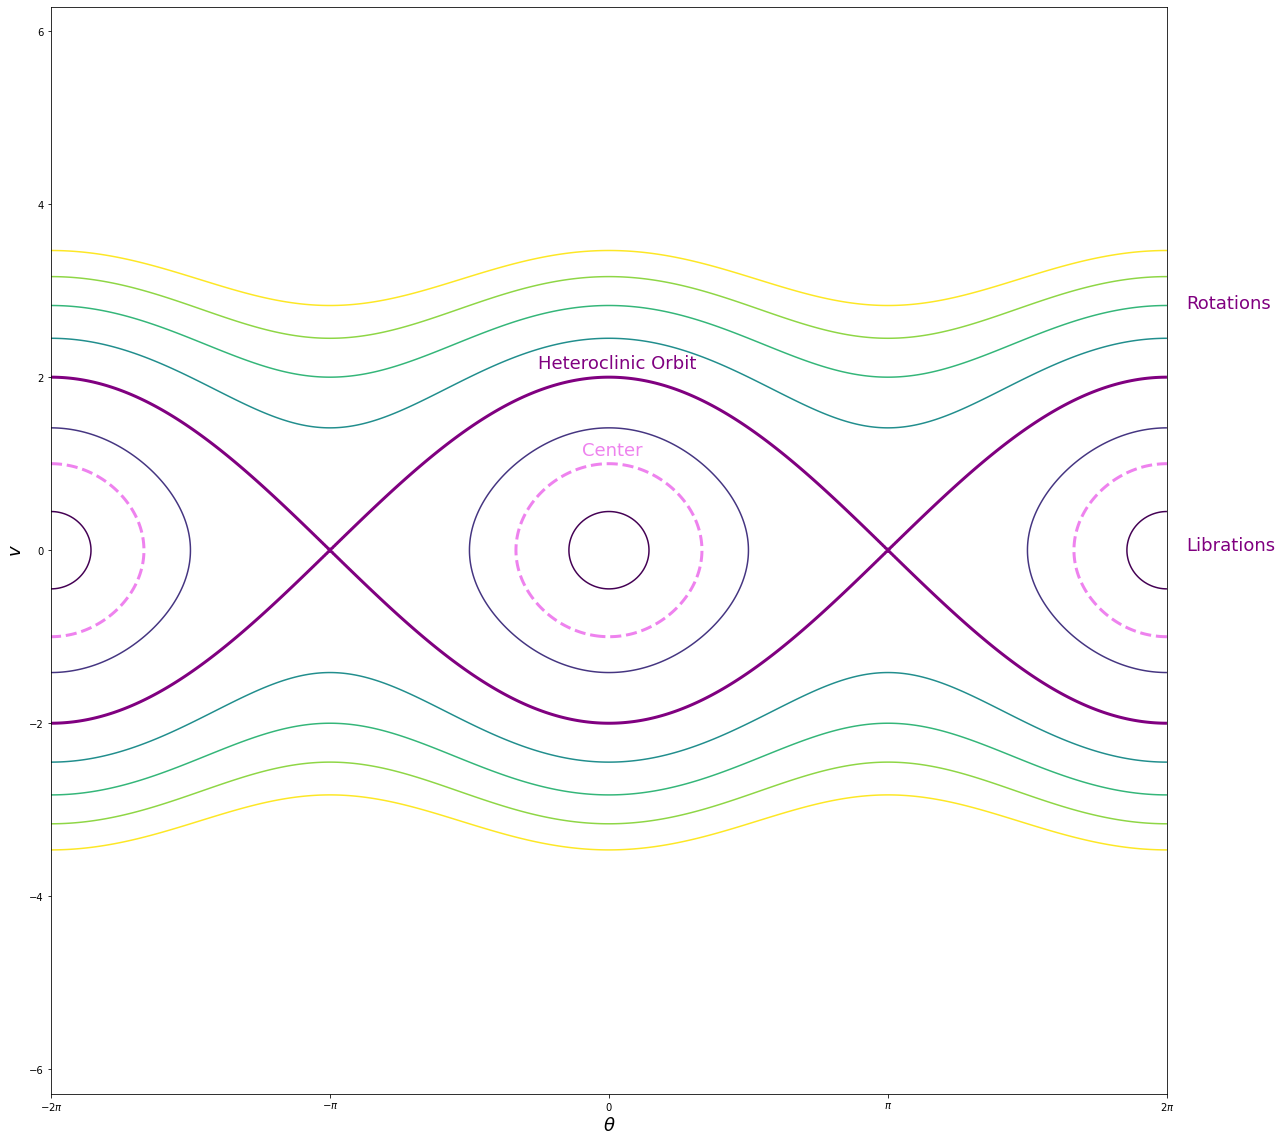

In [2]:
coords = np.linspace(-2 * np.pi, 2 * np.pi, 500)
X, Y = np.meshgrid(coords, coords)
Z = 0.5 * (Y**2) - np.cos(X)

plt.contour(X, Y, Z, [-0.9, 0, 2, 3, 4, 5])
plt.contour(X, Y, Z, [1], colors='purple', linewidths=3)
plt.text(-0.8, 2.1, "Heteroclinic Orbit", fontsize=18, color='purple')
plt.contour(X, Y, Z, [-0.5], colors='violet', linewidths=3)
plt.text(-0.3, 1.1, "Center", fontsize=18, color='violet')
plt.xlabel("$\\theta$", fontsize=18)
plt.ylabel("$v$", fontsize=18)
plt.xticks([-2 * np.pi, -np.pi, 0, np.pi, 2 * np.pi], ["$-2\pi$", "$-\pi$", "$0$", "$\pi$", "$2\pi$"])
plt.text(6.5, 0, "Librations", fontsize=18, color="purple")
plt.text(6.5, 2.8, "Rotations", fontsize=18, color="purple")
plt.show()

Note that the heteroclinic orbit is physically homoclinic (and is in e.g. a cylindrical phase space)

### Friction

$$
\begin{equation}
\ddot{\theta} + b\dot{\theta} + \sin{\theta} = 0
\end{equation}
$$
Can be rewritten in 2D as $\dot{\theta} = v$ and $\dot{v} = -bv - \sin{\theta}$

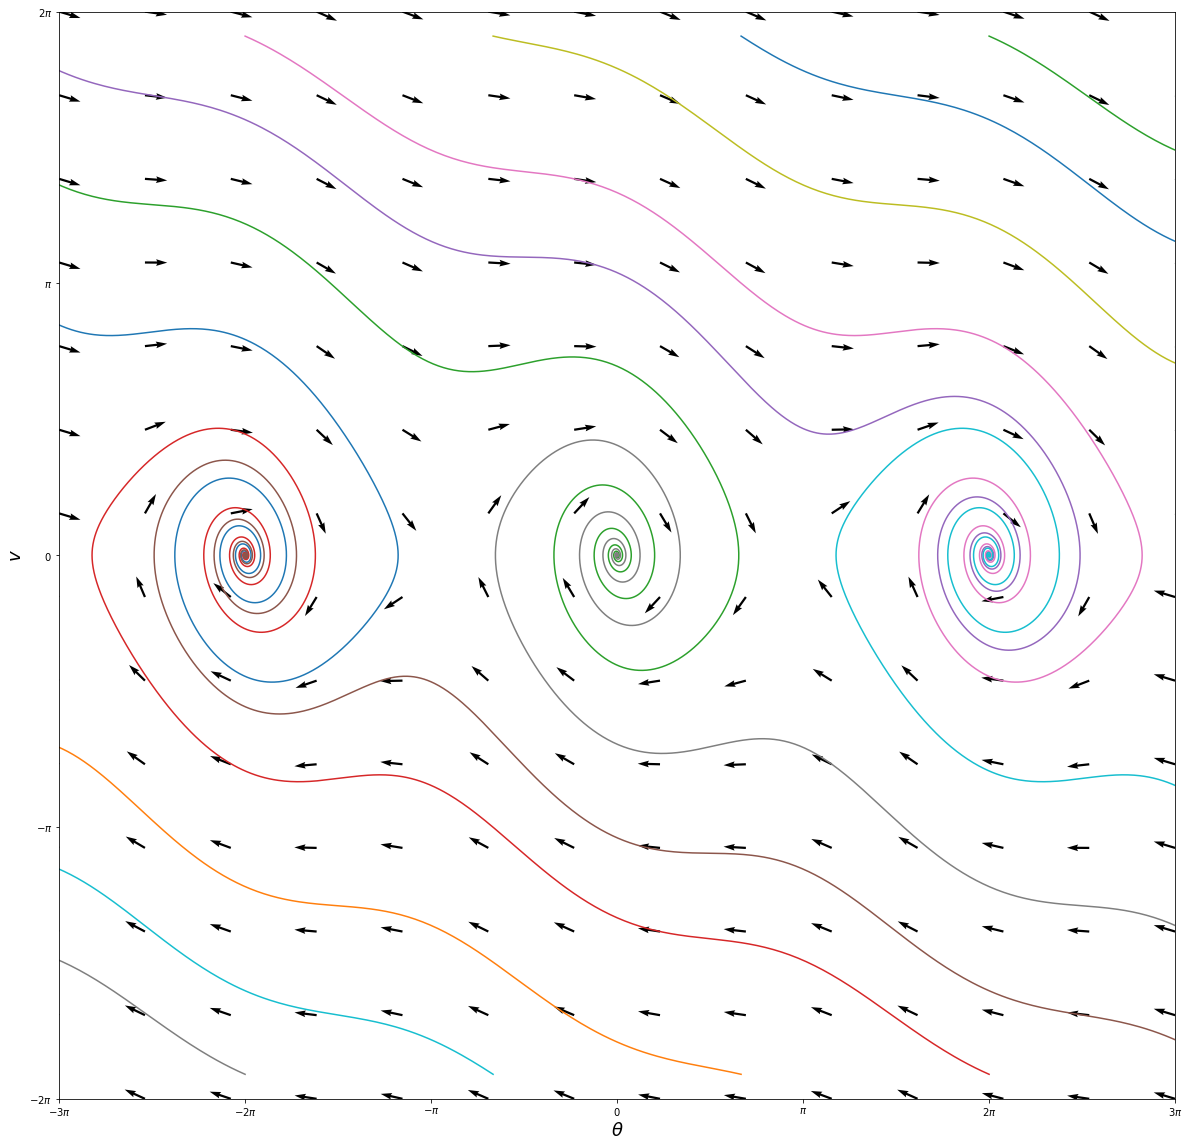

In [3]:
b = 0.3

def friction_pendulum(t, y):
  return [y[1], -b * y[1] - np.sin(y[0])]

initial_thetas = np.linspace(-6 * np.pi, 6 * np.pi, 10)
initial_conds = np.transpose([initial_thetas.repeat(2), np.tile([6, -6], len(initial_thetas))])

plot_second_order_phase_portrait(friction_pendulum, initial_conds, [[-3 * np.pi, 3 * np.pi], [-2 * np.pi, 2 * np.pi]])

plt.xlabel("$\\theta$", fontsize=18)
plt.ylabel("$v$", fontsize=18)
plt.xticks([-3 * np.pi, -2 * np.pi, -np.pi, 0, np.pi, 2 * np.pi, 3 * np.pi], ["$-3\pi$", "$-2\pi$", "$-\pi$", "$0$", "$\pi$", "$2\pi$", "$3\pi$"])
plt.yticks([-2 * np.pi, -np.pi, 0, np.pi, 2 * np.pi], ["$-2\pi$", "$-\pi$", "$0$", "$\pi$", "$2\pi$"])

plt.show()

## Index Theory

- Let $C$ be a simple smooth curve which doesn't pass through any fixed points, defined $\phi(\mathbf{x}) = \arctan(\frac{\dot{y}}{\dot{x}})$ to be the angle between the vector field at $\mathbf{x}$ and the x-axis. The **index** of $C$ is defined as $I_C = \frac{1}{2\pi}[\phi]_C$ where $[\phi]_C$ is the net change in $\phi$ over one circuit around $C$
  - As the phase plane is a vector field, $\phi$ must be the same at the start and end, so $I_C \in \mathbb{N}$
  - If $C, C'$ are homeomorphic, $I_C$ must vary continuously between them, but as $I_C$ is an integer it follows that $I_C = I_C'$
    - Means that each fixed point has a unique associated index
  - For any trajectory, as it doesn't intersect itself, $I_C = 1$
  - For a curve surrounding multiple fixed points, the curve can be shrunk so that it encloses each point in a circle with a *bridge* of infinitesimal width connecting the points, the change in angle along the bridge must be the same in both directions, thus the index is the sum of the indexes of the fixed points

## Exercises

### 6.1.8 - 6.1.11

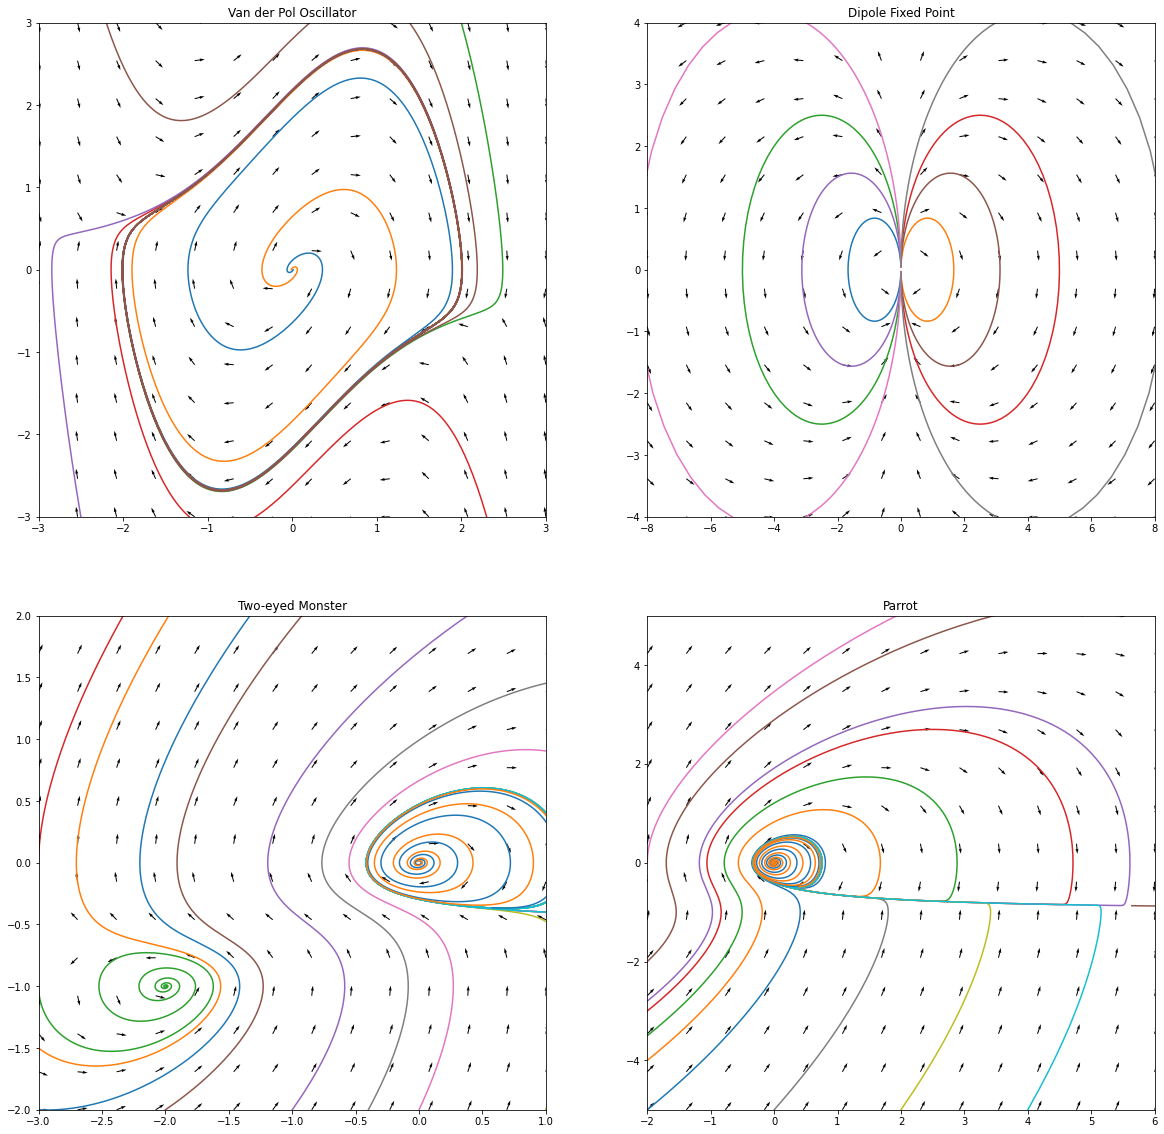

In [4]:
def van_der_pol_oscillator(t, y):
  return [y[1], -y[0] + y[1] * (1 - y[0] ** 2)]

def dipole_fixed_point(t, y):
  return [2 * y[0] * y[1], y[1] ** 2 - y[0] ** 2]

def two_eyed_monster(t, y):
  return [y[1] + y[1] ** 2, -.5 * y[0] + .2 * y[1] - y[0] * y[1] + 1.2 * y[1] ** 2]

def parrot(t, y):
  return [y[1] + y[1] ** 2, -y[0] + .2 * y[1] - y[0] * y[1] + 1.2 * y[1] ** 2]

plt.subplot(221)
plt.title("Van der Pol Oscillator")
plot_second_order_phase_portrait(van_der_pol_oscillator, [[.01, 0], [-.01, 0], [2, 3], [2.3, -3], [-2.5, -3], [-2.2, 3]], [[-3, 3], [-3, 3]])

plt.subplot(222)
plt.title("Dipole Fixed Point")
plot_second_order_phase_portrait(dipole_fixed_point, [[-.0015, .05], [.0015, .05], [-.0005, .05], [.0005, .05], [-.0008, .05], [.0008, .05], [-.0003, .05], [.0003, .05]], [[-8, 8], [-4, 4]])

plt.subplot(223)
plt.title("Two-eyed Monster")
plot_second_order_phase_portrait(two_eyed_monster, [[-3, -2], [-3, -1.5], [-3, -1], [-3, 0], [-1, -2], [-2, -2], [0, -2], [-0.4, -2], [1, -2], [2, -2], [.01, .01], [-.01, .01]], [[-3, 1], [-2, 2]])

plt.subplot(224)
plt.title("Parrot")
plot_second_order_phase_portrait(parrot, [[-2, -5], [-2, -4], [-2, -3.5], [-2, -3], [-2, -2.8], [-2, -2], [-2, 0], [0, -5], [2, -5], [4, -5], [.01, .01], [-.01, .01]], [[-2, 6], [-5, 5]])

### Exercise 6.3.10

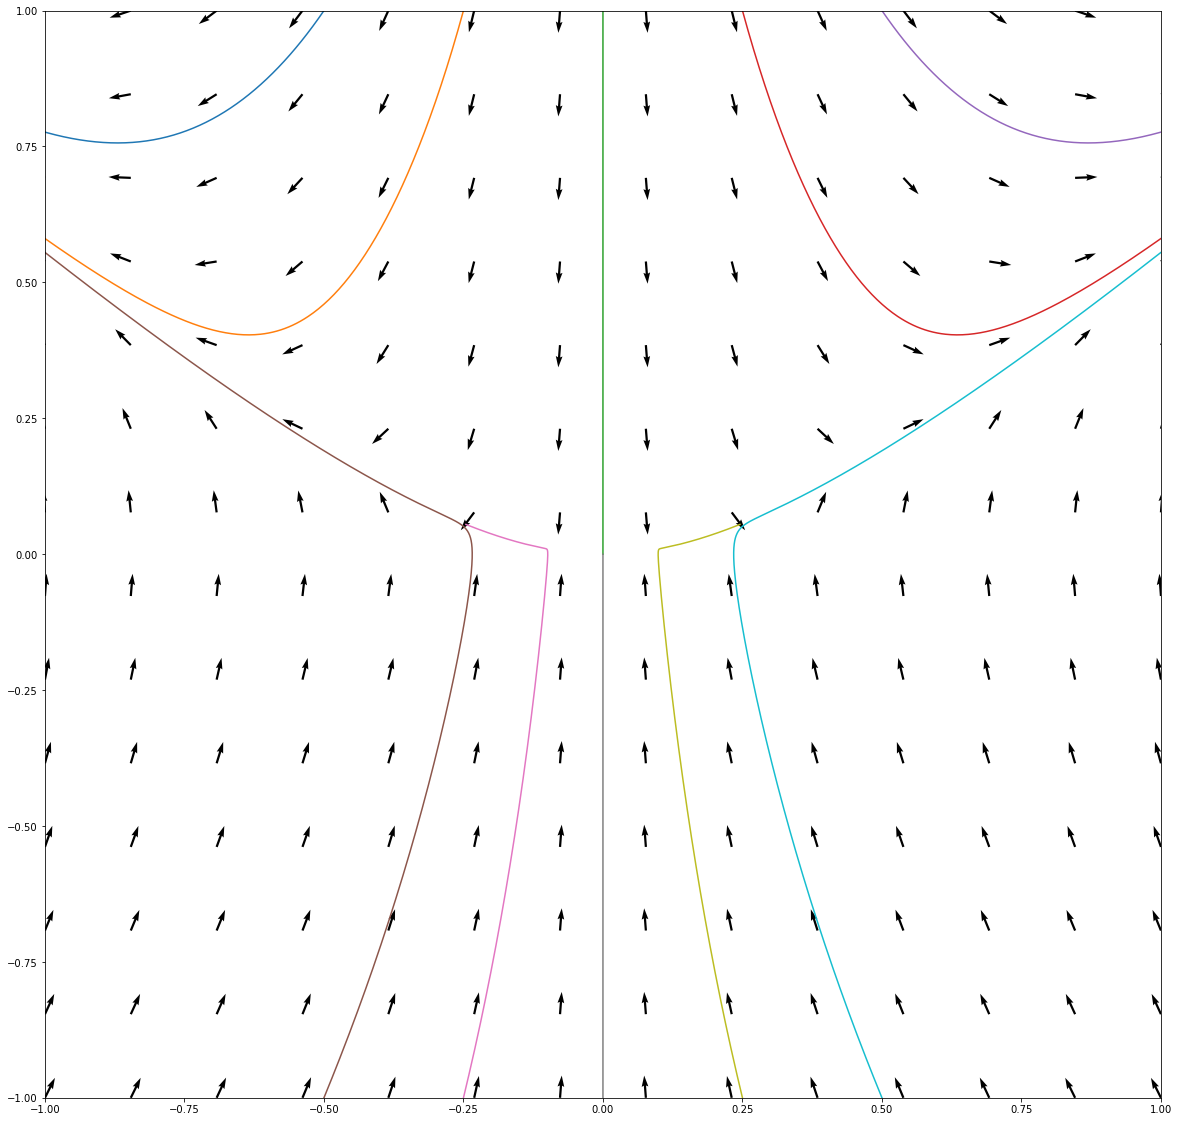

In [5]:
plot_second_order_phase_portrait(lambda t, y: [y[0] * y[1], y[0] ** 2 - y[1]], [[-.5, 1], [-.25, 1], [0, 1], [.25, 1], [.5, 1], [-.5, -1], [-.25, -1], [0, -1], [.25, -1], [.5, -1]], [[-1, 1], [-1, 1]])

### Exercise 6.3.16

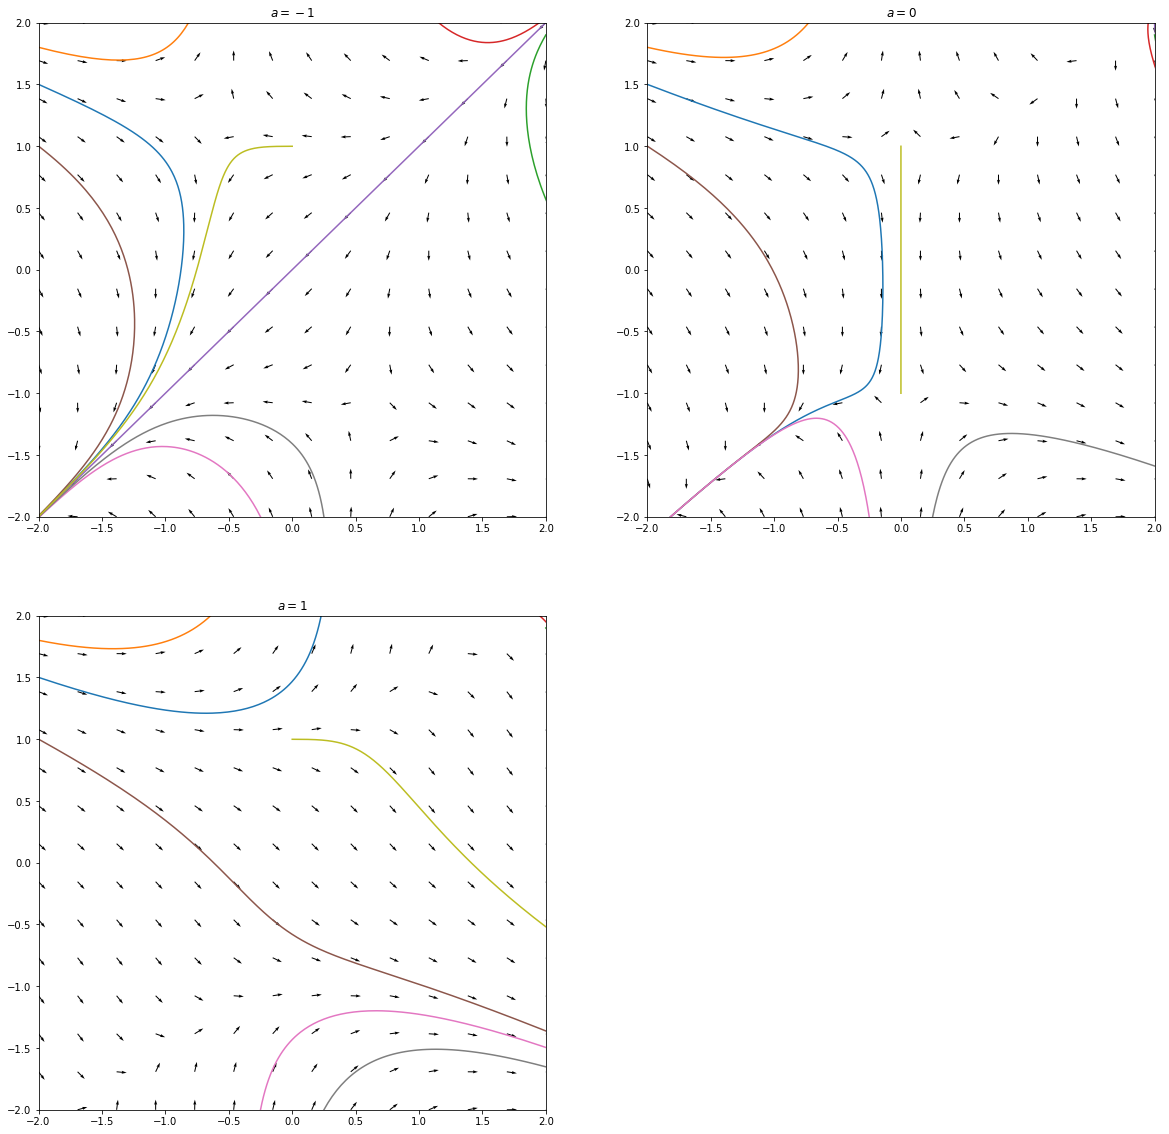

In [6]:
for idx, a in enumerate([-1, 0, 1], start=1):
  plt.subplot(2, 2, idx)
  plot_second_order_phase_portrait(lambda t, y: [a + y[0]**2 - y[0] * y[1], y[1] ** 2 - y[0] ** 2 - 1], [[-2, 1.5], [-2, 1.8], [2, 1.9], [1.95, 2], [2, 2], [-2, 1], [-.25, -2], [.25, -2], [0, .999]], [[-2, 2], [-2, 2]])
  plt.title(f"$a = {a}$")

### Exercise 6.5.10
Plot for a particle governed by an inverse-square force with Hamiltonian $H(p, r) = \frac{1}{2}p^2 + \frac{h^2}{2r} - \frac{k}{r}$, $h$ is the angular momentum and $k > 0$ is the force constant (an attractive force here)

(0.0, 6.0)

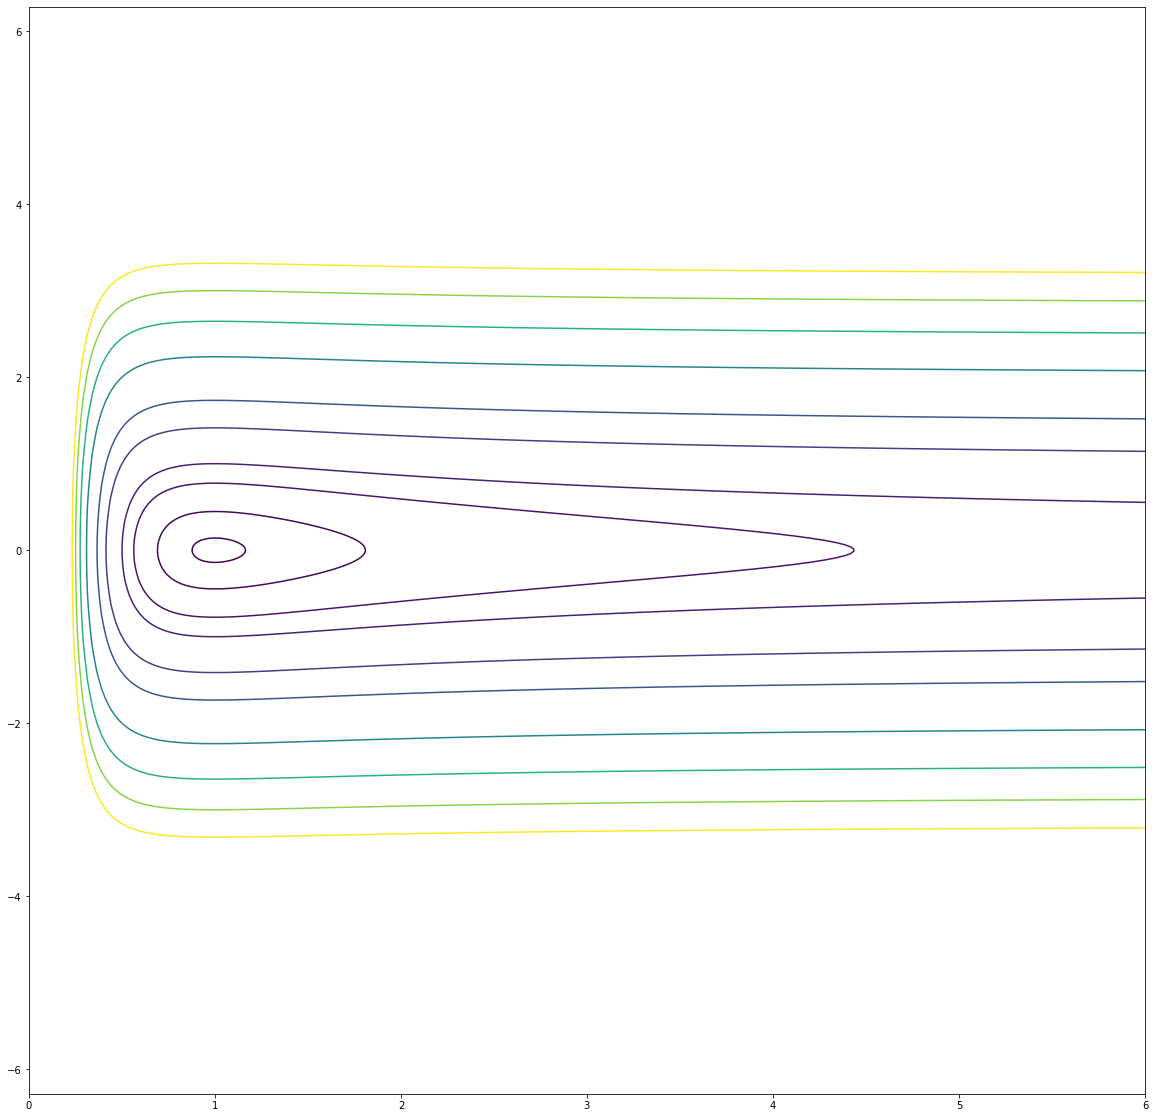

In [7]:
coords = np.linspace(-2 * np.pi, 2 * np.pi, 500)
X, Y = np.meshgrid(coords, coords)
Z = 0.5 * Y ** 2 + 1/(2 * X ** 2) - 1/X

plt.contour(X, Y, Z, [-.49, -.4, -.2, 0, 0.5, 1, 2, 3, 4, 5])
plt.xlim([0, 6])

### Exercise 6.6.4

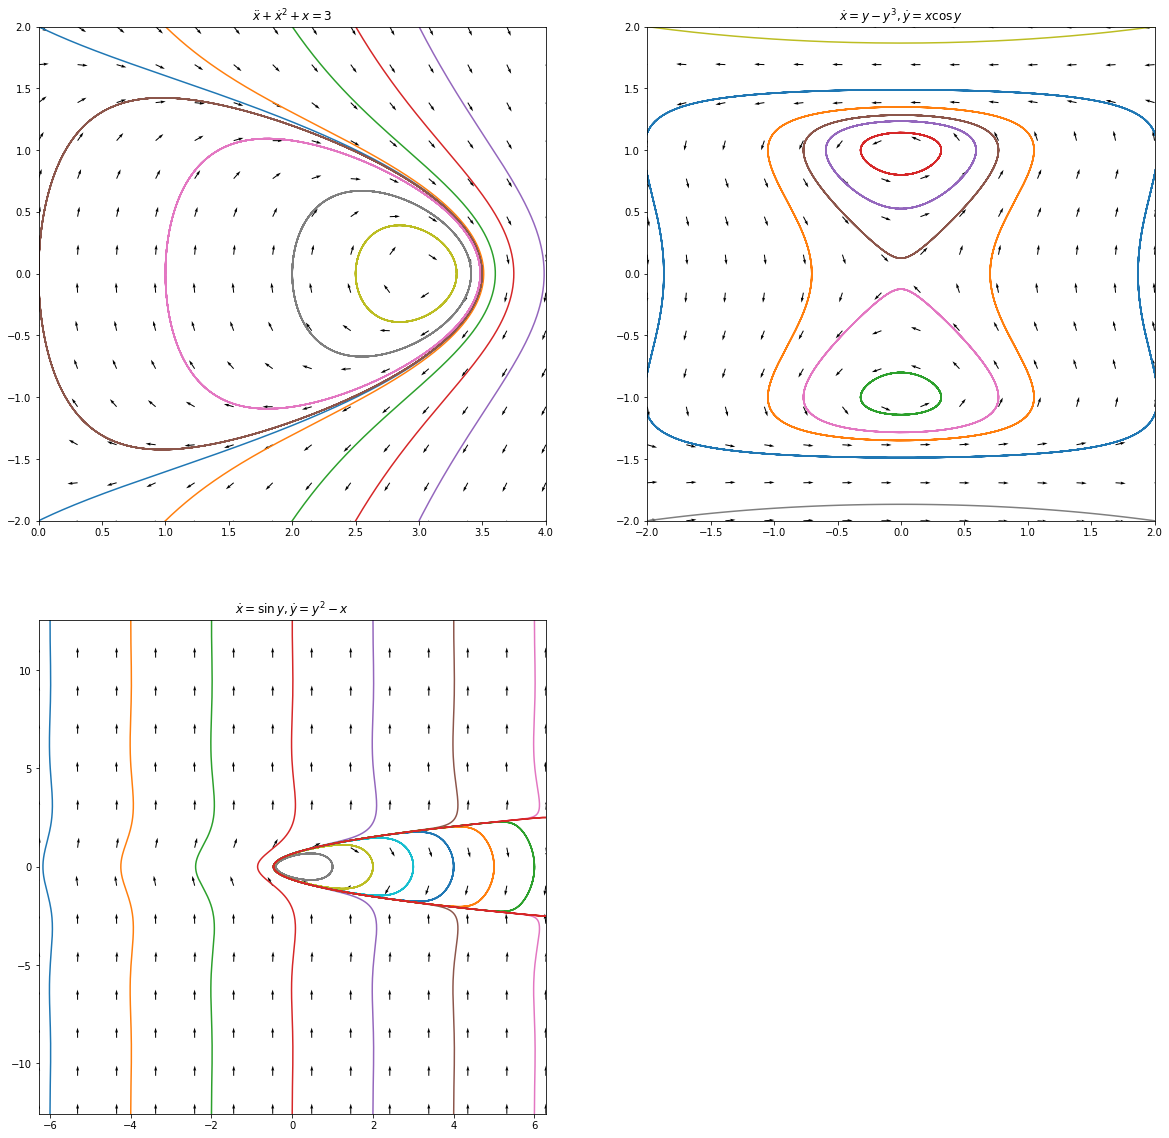

In [8]:
def generate_edge_initial_conditions(xy_range, num_points_on_edge):
  return [[xy_range[0][0], y] for y in np.linspace(xy_range[0][0], xy_range[0][1], num_points_on_edge)] \
      + [[xy_range[0][1], y] for y in np.linspace(xy_range[0][0], xy_range[0][1], num_points_on_edge)] \
      + [[x, xy_range[1][0]] for x in np.linspace(xy_range[1][0], xy_range[1][1], num_points_on_edge)] \
      + [[x, xy_range[1][1]] for x in np.linspace(xy_range[0][0], xy_range[1][1], num_points_on_edge)]

plt.subplot(2, 2, 1)
plt.title("$\ddot{x} + \dot{x}^2 + x = 3$")
plot_second_order_phase_portrait(lambda t, y: [y[1], 3 - y[1] ** 2 - y[0]], [
    [0, 2],
    [1, 2],
    [2, 2],
    [2.5, 2],
    [3, 2],
    [0, 0],
    [1, 0],
    [2, 0],
    [2.5, 0],
  ], [[0, 4], [-2, 2]])
plt.subplot(2, 2, 2)
plt.title("$\dot{x} = y - y^3, \dot{y} = x\cos{y}$")
plot_second_order_phase_portrait(lambda t, y: [y[1] - y[1] ** 3, y[0] * np.cos(y[1])], [
    [-2, -0.8],
    [-1, -0.8],
    [0, -0.8],
    [0, 0.8],
    [.5, 0.8],
    [.7, 0.8],
    [.7, -0.8],
    [-2, -2],
    [2, 2],
  ], [[-2, 2], [-2, 2]])
plt.subplot(2, 2, 3)
plt.title("$\dot{x} = \sin{y}, \dot{y} = y^2 - x$")
plot_second_order_phase_portrait(lambda t, y: [np.sin(y[1]), y[1] ** 2 - y[0]], [
    [-6, -4 * np.pi],
    [-4, -4 * np.pi],
    [-2, -4 * np.pi],
    [0, -4 * np.pi],
    [2, -4 * np.pi],
    [4, -4 * np.pi],
    [6, -4 * np.pi],

    [1, 0],
    [2, 0],
    [3, 0],
    [4, 0],
    [5, 0],
    [6, 0],
    [7, 0],
  ], [[-2 * np.pi, 2 * np.pi], [-4 * np.pi, 4 * np.pi]])